# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [9]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

  Using cached https://files.pythonhosted.org/packages/89/3e/31c2e5385d7588016c6f7ac552e81c3fff2bef4bc61b6f82f8177752405c/Pillow-6.2.1-cp37-cp37m-manylinux1_x86_64.whl
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/lib/python3.7/site-packages/PIL'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE


plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [11]:
opt = {
    'image_size': 32,
    'is_grayscale': True,
    'val_split': 0.75
}

### Load Dataset

In [12]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [13]:

X = {}
y = {}
N = {}
H = {}
W = {}
C = {}

In [14]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X["IMFDB"],y["IMFDB"] = load_data(dirpath)
N["IMFDB"],H["IMFDB"],W["IMFDB"] = X["IMFDB"].shape[0:3]
C["IMFDB"] = 1 if opt['is_grayscale'] else X["IMFDB"].shape[3]

Dataset shape: (400, 32, 32)


In [15]:
# Loading the dataset
# eg.
dirpath = './dataset/Yale_face_database/'
X["Yale"],y["Yale"] = load_data(dirpath)
N["Yale"],H["Yale"],W["Yale"] = X["Yale"].shape[0:3]
C["Yale"] = 1 if opt['is_grayscale'] else X["Yale"].shape[3]

Dataset shape: (165, 32, 32)


In [16]:
# Loading the dataset
# eg.
dirpath = './dataset/IIIT-CFW/'
X["CFW"],y["CFW"] = load_data(dirpath)
N["CFW"],H["CFW"],W["CFW"] = X["CFW"].shape[0:3]
C["CFW"] = 1 if opt['is_grayscale'] else X["CFW"].shape[3]

Dataset shape: (672, 32, 32)


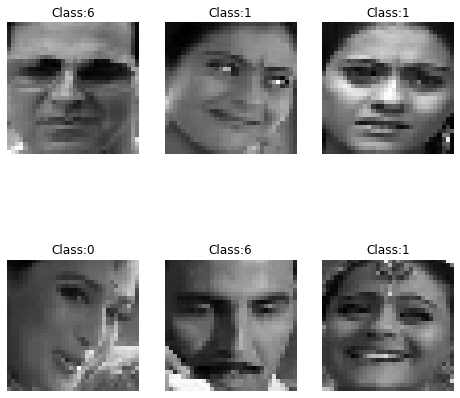

In [17]:
# Show sample images
ind = np.random.randint(0,y["IMFDB"].shape[0],6)
disply_images(X["IMFDB"][ind,...],y["IMFDB"][ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [18]:
# Flatten to apply PCA/LDA
for set_name,data in X.items():
    X[set_name] = X[set_name].reshape((N[set_name],H[set_name]*W[set_name]*C[set_name]))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [56]:
def get_pca(X,k,fit_inverse=False):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k,pca

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [20]:
def get_kernel_pca(X, k,kernel='rbf', degree=3,fit_inverse=False):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree,fit_inverse_transform=fit_inverse)
    X_k = kpca.fit_transform(X)
    return X_k,kpca

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [21]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k,lda

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [22]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k, klda

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [23]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

In [24]:
vgg_features_imfdb = get_vgg_features("./dataset/IMFDB")
print(vgg_features_imfdb.shape)
print(vgg_features_imfdb)

(400, 4096)
[[0.24513105 0.66970992 0.         ... 0.07281978 0.52367622 0.        ]
 [0.         0.3153466  0.         ... 0.         0.         0.        ]
 [0.25968912 1.06564081 0.         ... 0.2802197  1.131881   0.        ]
 ...
 [0.         2.8001585  0.         ... 0.         0.         0.        ]
 [0.         1.2056092  0.         ... 0.         0.58588988 0.        ]
 [0.         1.25162017 0.         ... 0.         0.         0.        ]]


### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [25]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________

Eigenfaces is the name given to a set of eigenvectors when they are used in the computer vision problem of human face recognition. The eigenvectors are derived from the covariance matrix of the probability distribution over the high-dimensional vector space of face images. The eigenfaces themselves form a basis set of all images used to construct the covariance matrix. This produces dimension reduction by allowing the smaller set of basis images to represent the original training images. Classification can be achieved by comparing how faces are represented by the basis set. 


1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples and make a convincing argument.


By a rule of thumb, we choose the number of eigen values based on how many it takes to cover 95% of variance. Those would correspond to the number of eigen vectors required.

In [26]:
# Compute your features 

X_3D = {}
trained_solvers = {}
solver_types = ["pca","kpca","lda","klda"]
feature_types = ["normal","vgg","resnet"]

## Initialize
# X_3D
X_3D = dict.fromkeys(X.keys(),{})
for key,val in X_3D.items():
    X_3D[key] = dict.fromkeys(feature_types,{})
for key,val in X_3D.items():
    for key_sub,val_sub in val.items():
        X_3D[key][key_sub] = dict.fromkeys(solver_types)

# Trained solver
trained_solvers = dict.fromkeys(X.keys(),{})
for key,val in X_3D.items():
    trained_solvers[key] = dict.fromkeys(feature_types,{})
for key,val in X_3D.items():
    for key_sub,val_sub in val.items():
        trained_solvers[key][key_sub] = dict.fromkeys(solver_types)

print(trained_solvers)
for set_name,data in X.items():
    for feature_type in feature_types:
        for solver_type in solver_types:
            X_3D[set_name][feature_type][solver_type],trained_solvers[set_name][feature_type][solver_type] = get_pca(X[set_name],3)
            X_3D[set_name][feature_type][solver_type],trained_solvers[set_name][feature_type][solver_type] = get_kernel_pca(X[set_name],3)
            X_3D[set_name][feature_type][solver_type],trained_solvers[set_name][feature_type][solver_type] = get_lda(X[set_name],y[set_name],3)
            X_3D[set_name][feature_type][solver_type],trained_solvers[set_name][feature_type][solver_type] = get_kernel_lda(X[set_name],y[set_name],3)


{'IMFDB': {'normal': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}, 'vgg': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}, 'resnet': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}}, 'Yale': {'normal': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}, 'vgg': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}, 'resnet': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}}, 'CFW': {'normal': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}, 'vgg': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}, 'resnet': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}}}


/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/discrimi

/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/discrimi

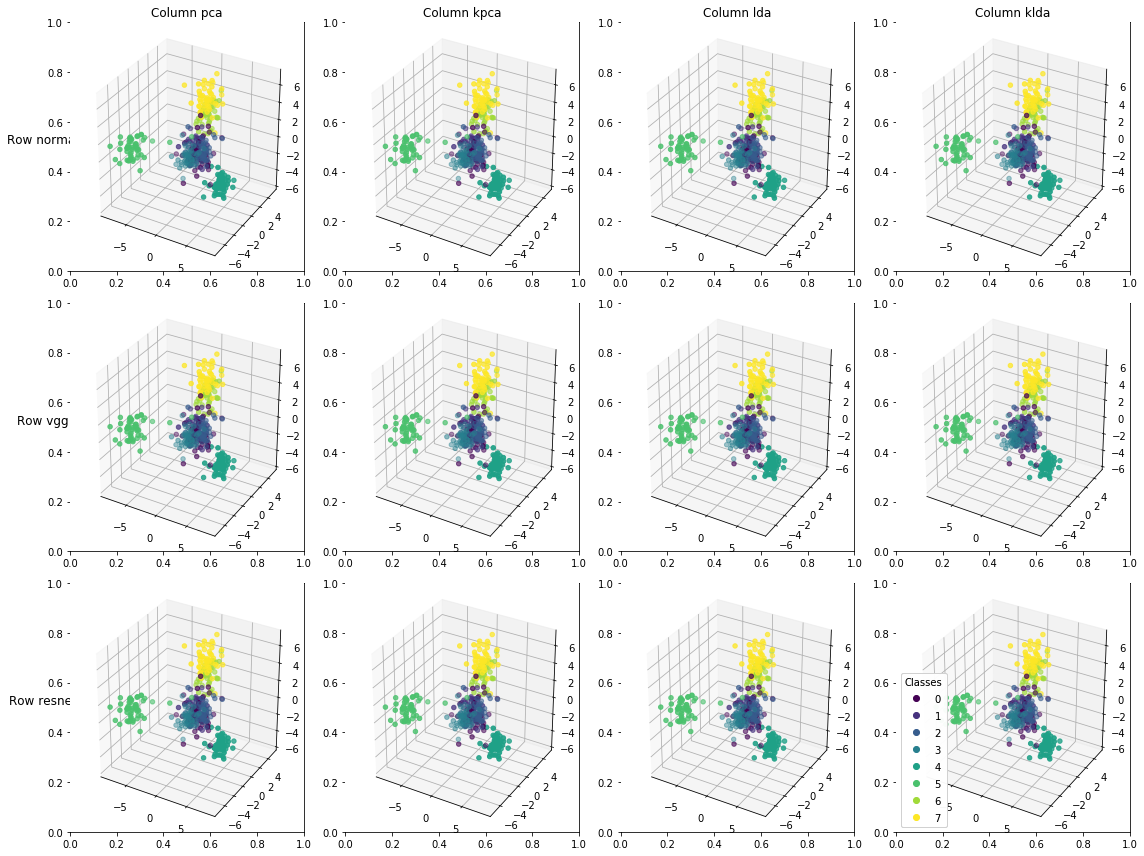

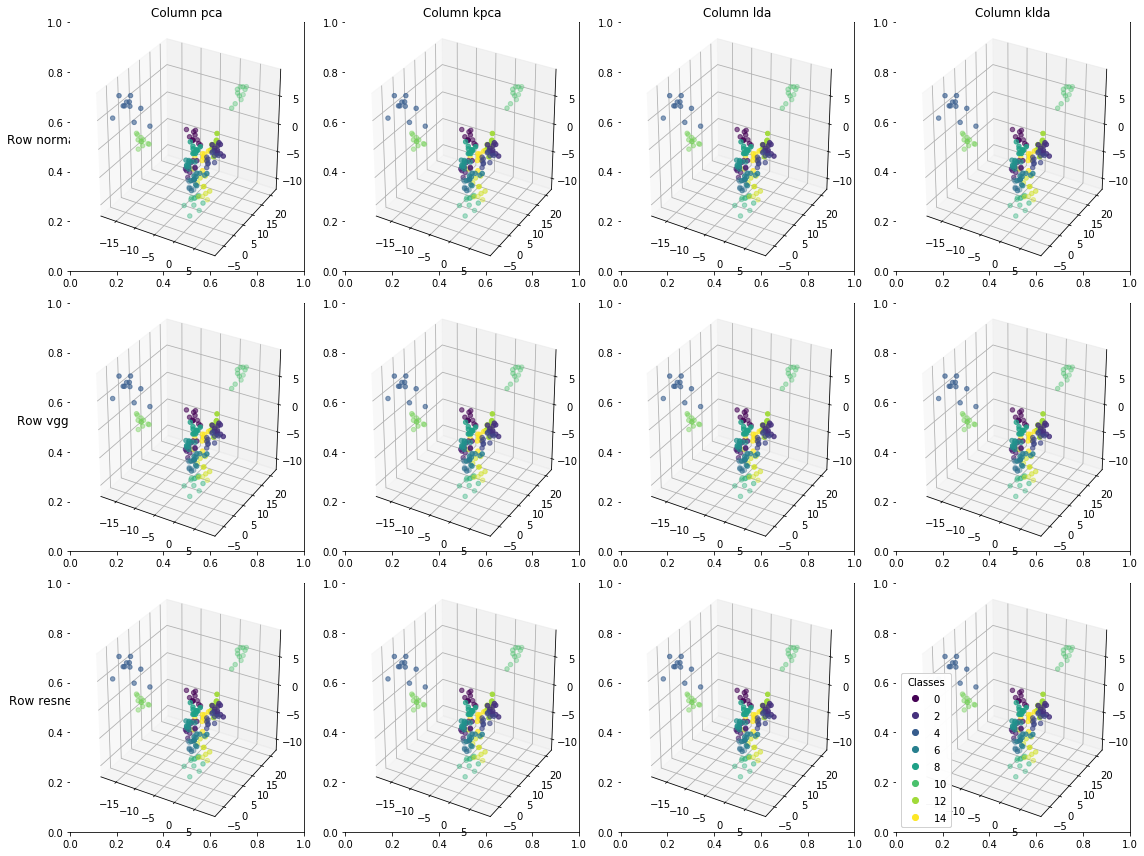

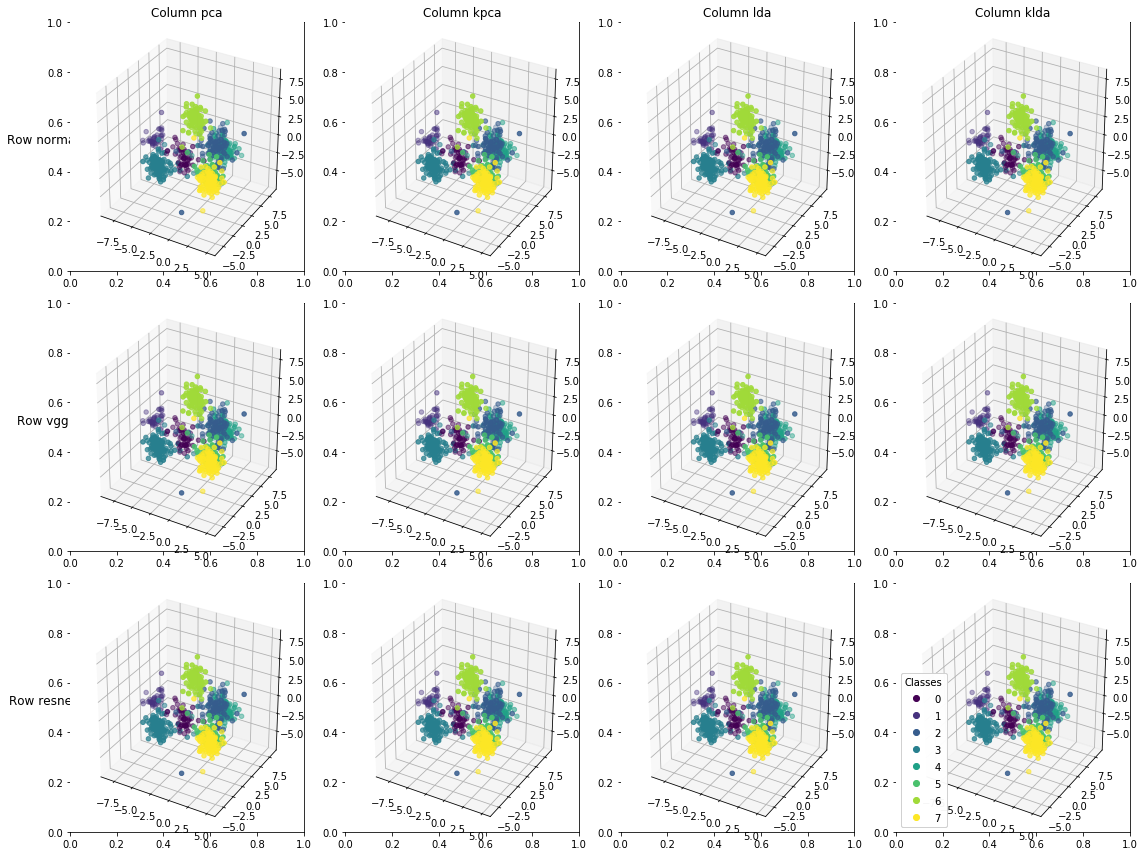

In [27]:
# Create a scatter plot  
# eg.

for set_name,data in X.items():
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
    index_subplot = 1
    for feature_type in feature_types:
        for solver_type in solver_types:
            ax = fig.add_subplot(3,4,index_subplot, projection='3d')
            scatter = ax.scatter(X_3D[set_name][feature_type][solver_type][:,0],X_3D[set_name][feature_type][solver_type][:,1],X_3D[set_name][feature_type][solver_type][:,2],c=y[set_name])
            index_subplot+=1

    handles,labels = scatter.legend_elements()
    legend1 = ax.legend(handles,labels, loc="lower left", title="Classes")
    ax.add_artist(legend1)

    cols = ['Column {}'.format(col) for col in solver_types]
    rows = ['Row {}'.format(row) for row in feature_types]
    for ax, col in zip(axes[0], cols):
        ax.set_title(col)

    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=0, size='large')

    fig.tight_layout()


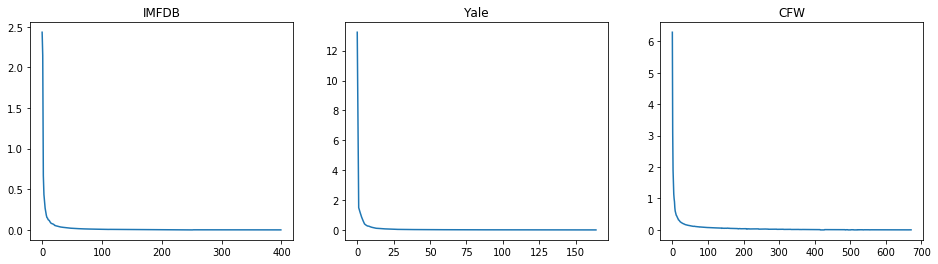

In [28]:
# Plot the eigen value spectrum 

num_eigenvals = {}
eigenvals = {}
num_eigenvals = {}
fig = plt.figure(figsize=(16,4))
index_subplot = 1
for set_name,data in X.items():
    cov_mat = np.cov(X[set_name])
    eigenvals[set_name], _ = np.linalg.eig(cov_mat.T)
    num_eigenvals[set_name] = [_iter_eval for _iter_eval in range(len(eigenvals[set_name]))]
    ax = fig.add_subplot(1,3,index_subplot)
    ax.plot(num_eigenvals[set_name], eigenvals[set_name])
    ax.title.set_text(set_name)
    
    index_subplot+=1

plt.show()

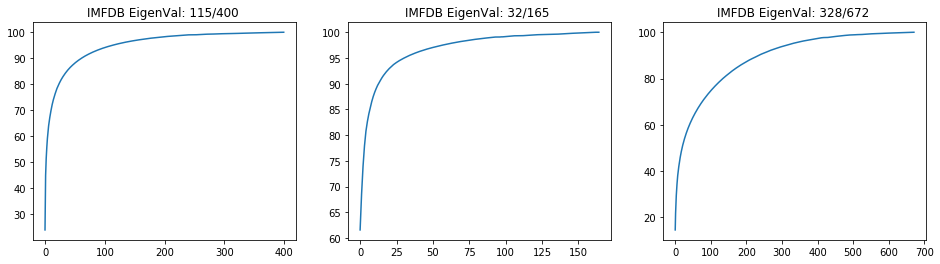

In [29]:
'''
    By a rule of thumb, we choose the number of eigen values based on how many it takes to cover 95% of variance.
'''
fig = plt.figure(figsize=(16,4))

chosen_eigvals = dict.fromkeys(X.keys(),0)
total_var = dict.fromkeys(X.keys(),0)
cumulative = dict.fromkeys(X.keys(),0)

index_subplot = 1
for set_name,data in X.items():
    total_var[set_name] = np.sum(eigenvals[set_name])
    # Cumulative variance with eigen values
    cumulative[set_name] = np.cumsum(eigenvals[set_name])*100/total_var[set_name]
    chosen_eigvals[set_name] = np.argmax(cumulative[set_name]>95)+1
    ax = fig.add_subplot(1,3,index_subplot)
    ax.plot(num_eigenvals[set_name], cumulative[set_name])
    ax.title.set_text("IMFDB EigenVal: {}/{} ".format(str(chosen_eigvals[set_name]),str(len(eigenvals[set_name]))))

    index_subplot+=1

1(c). Reconstruct  the  image  back for each case


/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/utils/extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


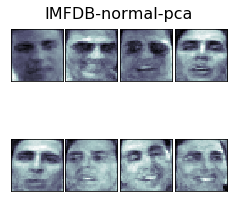

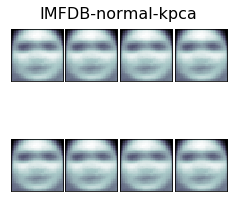

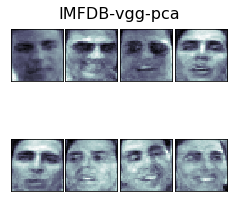

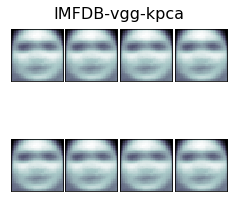

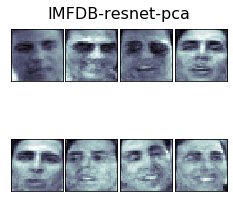

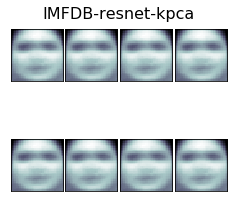

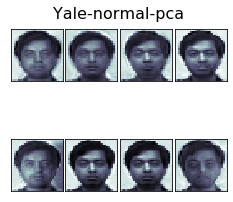

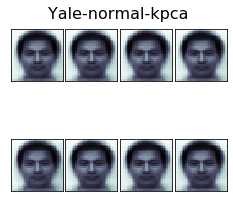

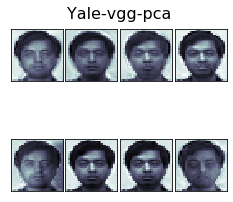

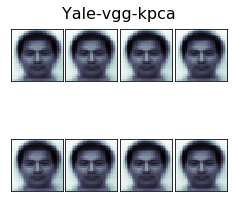

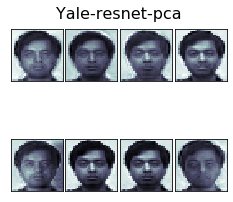

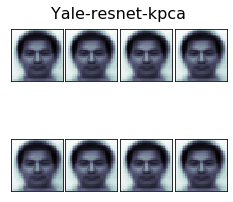

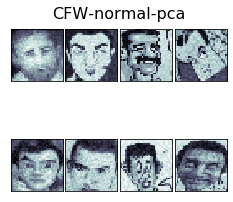

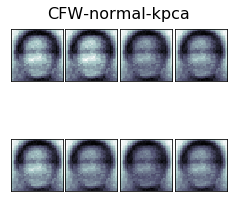

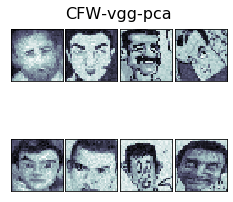

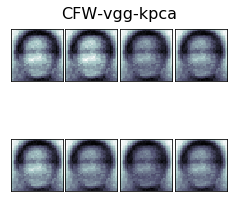

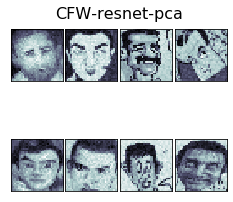

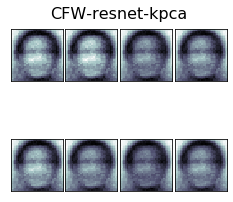

In [62]:
def reconstruct_images(solver,solver_type,X_compressed,*args,**kwargs):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    
    reconstruct_X = solver.inverse_transform(X_compressed)

    reconstruct_X = np.reshape(reconstruct_X,(-1,32,32))

    fig = plt.figure(figsize=(3,3))
    fig.suptitle(solver_type, fontsize=16)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
    # plot the faces, each image is 64 by 64 dimension but 8x8 pixels 
    for i in range(8): 
        ax = fig.add_subplot(2,4, i+1, xticks=[], yticks=[]) 
        ax.imshow(reconstruct_X[i], cmap=plt.cm.bone, interpolation='nearest')
    
    return reconstruct_X

X_compressed = {}
reconstruct_X = {}
for set_name,data in X.items():
    X_compressed[set_name] = dict.fromkeys(feature_types,{})
    reconstruct_X[set_name] = dict.fromkeys(feature_types,{})
    for feature_type in feature_types:
            X_compressed[set_name][feature_type]={'pca':None, 'kpca':None}
            reconstruct_X[set_name][feature_type]={'pca':None, 'kpca':None}

            X_compressed[set_name][feature_type]['pca'],solver = get_pca(data,chosen_eigvals[set_name],fit_inverse=True)
            _title = set_name+'-'+feature_type+'-pca'
            reconstruct_X[set_name][feature_type]['pca'] = reconstruct_images(solver,_title,X_compressed[set_name][feature_type]['pca'],set_name=set_name)
            X_compressed[set_name][feature_type]['kpca'],solver = get_kernel_pca(data,chosen_eigvals[set_name],fit_inverse=True)
            _title_k = set_name+'-'+feature_type+'-kpca'
            reconstruct_X[set_name][feature_type]['kpca'] = reconstruct_images(solver,_title_k,X_compressed[set_name][feature_type]['kpca'],set_name=set_name)

In [31]:
# Display results 
# X_reconstruced = reconstruct_images()

# Display random images
# ind = np.random.randint(0,y.shape[0],6)
# disply_images(X_reconstruced_3D[ind,...],y[ind],row=2,col=3)

# Show the reconstruction error
print("Reconstruction error -- ")
for set_name,data in X.items():
    print("{} : {}".format(set_name,str(np.sqrt(np.mean((X[set_name] - reconstruct_X[set_name].reshape(-1,1024))**2)))))

Reconstruction error -- 
IMFDB : 0.15976276524379343
Yale : 0.22410026411660097
CFW : 0.27875760484687917


1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

Difficult to represent -
1) Occlusions in photos.
2) The person having more emotions. 
3) The person whose images have higher translations and transformations.

Empirical observations can be done by evaluating the loss after reconstruction of the image.

Most of the people have enough diversity in their photos.
A few photos of Katrina's seem to have occlusions which may be the reason for higher loss.

In [32]:
# code goes here
y_imfdb_labels = [6,7,4,1,5,0,2,3]
for value in range(len(y_imfdb_labels)) :
    loss=(np.sqrt(np.mean((X["IMFDB"][value*50:(value+1)*50] - reconstruct_X["IMFDB"][value*50:(value+1)*50].reshape(-1,1024))**2)))
    print(list(imfdb_dict.keys())[y_imfdb_labels[value]], " has loss: ",loss)


AkshayKumar  has loss:  0.14789147415604145
Amir  has loss:  0.17904108278536734
AmitabhBachan  has loss:  0.1693262741758825
Kajol  has loss:  0.14536220597284677
KatrinaKaif  has loss:  0.19459550985596805
MadhuriDixit  has loss:  0.13819490542210552
SharukhKhan  has loss:  0.12424004214981832
ShilpaShetty  has loss:  0.167520569925152


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [33]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier():
    def __init__(self, ):
        super(Classifier, self).__init__()
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        prediction = self.mlp.predict(X)     
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.mlp = MLPClassifier(hidden_layer_sizes=(150,200,150), max_iter=500, activation = 'tanh',solver='adam',random_state=1)
        self.mlp.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        y_pred = self.mlp.predict(X_validate)
        confusion_mat = confusion_matrix(y_validate, y_pred)
        acc = accuracy_score(y_validate, y_pred)
        #print("Validation Accuracy: ", acc)
        scores = precision_recall_fscore_support(y_validate, y_pred, average='macro')
        #print("Precision, Recall, f1-score: ",scores[0], scores[1], scores[2])
        return scores[0], scores[2]

In [50]:
# Create a train and validation split to train your classifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

def train_model(X_data,y):
#     for i in range(len(method)):
        #print("Results of "+method_names[i]+" method:")
        X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.6, random_state=42)
        X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
        classifier = Classifier()
        classifier.train(X_train, y_train)
        precision, f1_score = classifier.validate(X_valid, y_valid)
        y_pred = classifier.classify(X_test)
        acc = accuracy_score(y_test, y_pred)
        
        return acc, precision, f1_score, y_test, y_pred
        

In [69]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

# Print the table. (You can use Pandas)
# method =[pca_X_3D, kpca_X_3D, lda_X_3D, klda_X_3D, vgg_lda_X_3D, res_lda_X_3D, vgg_pca_X_3D, res_pca_X_3D]
best_method = {}
best_confusion_mat = {}

for set_name,data in X.items():
    all_acc = []
    all_precision = []
    all_f1score = []
    method_names = []
    accuracy = 0
    confusion_mat1 = None
    for feature_type in feature_types:
        for solver_type in solver_types:
            method_names.append(feature_type+"-"+solver_type)
            if solver_type in ['pca','kpca']:
                _iter_X = X_compressed[set_name][feature_type][solver_type]
            else:
                _iter_X = X_3D[set_name][feature_type][solver_type]
#             print(solver_type, type(_iter_X))
#             print(set_name,feature_type,solver_type,_iter_X.shape)
            acc, precision, f1score, y_test, y_pred = train_model(_iter_X, y[set_name])
            all_acc.append(acc)
            all_precision.append(precision)
            all_f1score.append(f1score)
            if(accuracy<acc):
                best_confusion_mat[set_name] = confusion_matrix(y_test, y_pred)
                best_method[set_name] = feature_type+"-"+solver_type
                accuracy = acc

# method_names = ['PCA', 'Kernel PCA', 'LDA', 'Kernel LDA', 'VGGnet+LDA', 'Resnet+LDA', 'VGGnet+PCA','Resnet+LDA']

    
    df = pd.DataFrame()
    df.insert(0, "Feature", method_names)
    df.insert(1, "Dimension Space", [chosen_eigvals[set_name], chosen_eigvals[set_name],3,3]*3)
    df.insert(2, "Accuracy", all_acc)
    df.insert(3, "Precision", all_precision)
    df.insert(4, "f1-score", all_f1score)
    print(df)

        Feature  Dimension Space  Accuracy  Precision  f1-score
0    normal-pca              115  0.608333   0.668726  0.659682
1   normal-kpca              115  0.600000   0.617253  0.609804
2    normal-lda                3  0.741667   0.779443  0.776636
3   normal-klda                3  0.741667   0.779443  0.776636
4       vgg-pca              115  0.600000   0.674603  0.663074
5      vgg-kpca              115  0.600000   0.617253  0.609804
6       vgg-lda                3  0.741667   0.779443  0.776636
7      vgg-klda                3  0.741667   0.779443  0.776636
8    resnet-pca              115  0.608333   0.653771  0.636308
9   resnet-kpca              115  0.600000   0.617253  0.609804
10   resnet-lda                3  0.741667   0.779443  0.776636
11  resnet-klda                3  0.741667   0.779443  0.776636


/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/swish-coder/.virtualenvs/SMAI/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 

        Feature  Dimension Space  Accuracy  Precision  f1-score
0    normal-pca               32  0.877551   0.740000  0.728889
1   normal-kpca               32  0.816327   0.648519  0.674965
2    normal-lda                3  0.816327   0.787734  0.744815
3   normal-klda                3  0.816327   0.787734  0.744815
4       vgg-pca               32  0.877551   0.708889  0.710635
5      vgg-kpca               32  0.816327   0.648519  0.674965
6       vgg-lda                3  0.816327   0.787734  0.744815
7      vgg-klda                3  0.816327   0.787734  0.744815
8    resnet-pca               32  0.857143   0.714127  0.714141
9   resnet-kpca               32  0.816327   0.648519  0.674965
10   resnet-lda                3  0.816327   0.787734  0.744815
11  resnet-klda                3  0.816327   0.787734  0.744815
        Feature  Dimension Space  Accuracy  Precision  f1-score
0    normal-pca              328  0.331683   0.398494  0.364525
1   normal-kpca              328  0.3514

In [ ]:
# For each dataset print the confusion matrix for the best model 
print("Confusion matrix for ", best_method1)
print(best_model_confusion_mat1)

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

In [70]:
# Compute TSNE for different features and create a scatter plot
# print(X[:,1].shape)

## Initialize
# X_3D
X_3D = dict.fromkeys(X.keys(),{})
for key,val in X_3D.items():
    X_3D[key] = dict.fromkeys(feature_types,0)

# Trained solver
trained_solvers = dict.fromkeys(X.keys(),{})
for key,val in X_3D.items():
    trained_solvers[key] = dict.fromkeys(feature_types,{})
for key,val in X_3D.items():
    for key_sub,val_sub in val.items():
        trained_solvers[key][key_sub] = dict.fromkeys(solver_types)

print(trained_solvers)
## IMFDB
for set_name,data in X.items():
    for feature_type in feature_types:
        X_3D[set_name][feature_type][solver_type],trained_solvers[set_name][feature_type][solver_type] = get_pca(X[set_name],3)
X_feature = X.reshape(-1,1024) # feature 
k = 3 # Number of components in TSNE

# Compute
X_TSNE = TSNE(n_components=k).fit_transform(X_feature)

print(type(X_TSNE),X_TSNE.shape)
# Plot the representation in 2d/3d
for set_name,data in X.items():
    for feature_type in feature_types:
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

{'IMFDB': {'normal': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}, 'vgg': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}, 'resnet': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}}, 'Yale': {'normal': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}, 'vgg': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}, 'resnet': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}}, 'CFW': {'normal': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}, 'vgg': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}, 'resnet': {'pca': None, 'kpca': None, 'lda': None, 'klda': None}}}


TypeError: 'int' object does not support item assignment

In [ ]:
# Plot the representation in 2d/3d
X_tsne = X_yale.reshape(-1,1024)
colors_yale = ['y','b','c','k','m','g','r','orange', 'pink', 'brown' , 'gray']

from mpl_toolkits.mplot3d import Axes3D
k=3
fig = plt.figure()
ax= fig.add_subplot(111, projection='3d')
X_TSNE_3d = TSNE(n_components=k).fit_transform(X_tsne)
print(X_TSNE.shape)
for index , c in enumerate(colors_yale):
    ax.scatter(X_TSNE_3d[y_yale==index,0],X_TSNE_3d[y_yale==index,1],X_TSNE_3d[y_yale==index,2],color=c,label=index)
plt.legend(loc='upper left')
plt.title("TSNE 3D Scatter Plot on YALE")
plt.show()



4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [72]:
class FaceVerification():
    def __init__(self, ):
        super(FaceVerification, self).__init__()
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        verfication_results = self.knn.predict(X)             
        return verfication_results
        
    def train(self,X_train,y_train, k):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.knn = KNeighborsClassifier(n_neighbors=k)
        self.knn.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        y_pred = self.knn.predict(X_validate)
        confusion_mat = confusion_matrix(y_validate, y_pred)
        acc = accuracy_score(y_validate, y_pred)
        #print("Validation Accuracy: ", acc)
        scores = precision_recall_fscore_support(y_validate, y_pred, average='macro')
        #print("Precision, Recall, f1-score: ",scores[0], scores[1], scores[2])
        return scores[0], scores[2]

In [75]:
#  Create a train and validation split and show your results 
from sklearn.neighbors import KNeighborsClassifier

def train_face_model(X_data, y):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.6, random_state=42)
        X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
        classifier = FaceVerification()
        classifier.train(X_train, y_train)
        precision, f1_score = classifier.validate(X_valid, y_valid)
        y_pred = classifier.classify(X_test)
        acc = accuracy_score(y_test, y_pred)
        
        return acc, precision, f1_score, y_test, y_pred
        

In [76]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)
best_method = {}
best_confusion_mat = {}

for set_name,data in X.items():
    all_acc = []
    all_precision = []
    all_f1score = []
    method_names = []
    accuracy = 0
    confusion_mat1 = None
    for feature_type in feature_types:
        for solver_type in solver_types:
            method_names.append(feature_type+"-"+solver_type)
            if solver_type in ['pca','kpca']:
                _iter_X = X_compressed[set_name][feature_type][solver_type]
            else:
                _iter_X = X_3D[set_name][feature_type][solver_type]
#             print(solver_type, type(_iter_X))
#             print(set_name,feature_type,solver_type,_iter_X.shape)
            acc, precision, f1score, y_test, y_pred = train_face_model(_iter_X, y[set_name])
            all_acc.append(acc)
            all_precision.append(precision)
            all_f1score.append(f1score)
            if(accuracy<acc):
                best_confusion_mat[set_name] = confusion_matrix(y_test, y_pred)
                best_method[set_name] = feature_type+"-"+solver_type
                accuracy = acc

# method_names = ['PCA', 'Kernel PCA', 'LDA', 'Kernel LDA', 'VGGnet+LDA', 'Resnet+LDA', 'VGGnet+PCA','Resnet+LDA']

    
    df = pd.DataFrame()
    df.insert(0, "Feature", method_names)
    df.insert(1, "Dimension Space", [chosen_eigvals[set_name], chosen_eigvals[set_name],3,3]*3)
    df.insert(2, "Accuracy", all_acc)
    df.insert(3, "Precision", all_precision)
    df.insert(4, "f1-score", all_f1score)
    print(df)

TypeError: train() missing 1 required positional argument: 'k'

### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [ ]:
# Load data

In [ ]:
# Define your features

In [ ]:
# Create your classifier

# Validate your classifier

In [ ]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.

In [ ]:
# Show quantitative results such as examples of correct prediction and wrong prediction